In [49]:
#--------------------------------------------------------------------------------
# Module 1: Loading Pickled Data for GAN Model
#--------------------------------------------------------------------------------

import pickle
import os
import pandas as pd

# Ensure the directory "Processed data" exists before attempting to load the file
if os.path.exists("Processed data/data_encoded.pkl"):
    with open("Processed data/data_encoded.pkl", "rb") as file:
        data_encoded = pickle.load(file)

    # Display a sample of the loaded data
    print("Sample of the loaded data:")
    print(data_encoded.sample(5))  # Display 5 random rows
else:
    print("The pickled file does not exist in the specified directory.")



Sample of the loaded data:
       Upfront Payment  Leg 1 Fixed Rate  Leg 1 Spread  Leg 1 Notional  \
11710         0.496424          0.008930           0.0        0.000554   
30364         0.496424          0.008688           0.0        0.000202   
15382         0.496424          0.007784           0.0        0.000057   
12191         0.496424          0.003079           0.0        0.002016   
13105         0.496424          0.020216           0.0        0.000212   

       Leg 2 Fixed Rate  Event_Amendment  Event_BLENDING_REMNANT  \
11710          0.003358            False                   False   
30364          0.003358            False                   False   
15382          0.003358            False                   False   
12191          0.003358            False                   False   
13105          0.003358            False                   False   

       Event_Cancellation  Event_Clearing Novation  Event_Compression  ...  \
11710               False                

In [50]:
#--------------------------------------------------------------------------------
# Module 2: Define the Generator model
#--------------------------------------------------------------------------------

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout, GaussianNoise

# Define the size of the random noise input (latent dimension)
latent_dim = 100
num_features = data_encoded.shape[1]

def build_generator():
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(GaussianNoise(0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(num_features, activation='tanh'))

    return model

generator = build_generator()
generator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 256)               0         
                                                                 
 gaussian_noise_15 (Gaussia  (None, 256)               0         
 nNoise)                                                         
                                                                 
 batch_normalization_30 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_30 (Dropout)        (None, 256)               0         
                                                                 
 dense_41 (Dense)            (None, 512)             

In [51]:
#--------------------------------------------------------------------------------
# Module 3: Define the Discriminator model
#--------------------------------------------------------------------------------

from tensorflow.keras.regularizers import l2

def build_discriminator():
    model = Sequential()

    model.add(Dense(1024, input_dim=num_features, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(256, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(128, kernel_regularizer=l2(0.01)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 1024)              1808384   
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 1024)              0         
                                                                 
 batch_normalization_33 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_33 (Dropout)        (None, 1024)              0         
                                                                 
 dense_45 (Dense)            (None, 256)               262400    
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 256)               0         
                                                     

In [52]:
#--------------------------------------------------------------------------------
# Module 4: Combined GAN Structure
#   OBS! Discriminator trainable=False as we dont wants to change its weights 
#   while during this initial generator training process.
#--------------------------------------------------------------------------------

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Define MSE loss
mse_loss = MeanSquaredError()

# Ensure that the discriminator is not trainable when combined with the generator
discriminator.trainable = False

# Define the GAN's input (noise) and output (discriminator's probability for the generated sample)
gan_input = Input(shape=(latent_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)

# Define the combined GAN model
gan = Model(gan_input, gan_output)

# Compile the GAN using MSE loss and the same optimizer as the discriminator
gan.compile(loss=mse_loss, optimizer=Adam(0.0001, 0.5))

# Print the summary of the GAN model
gan.summary()



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_10 (Sequential)  (None, 1765)              2499045   
                                                                 
 sequential_11 (Sequential)  (None, 1)                 2109441   
                                                                 
Total params: 4608486 (17.58 MB)
Trainable params: 2495461 (9.52 MB)
Non-trainable params: 2113025 (8.06 MB)
_________________________________________________________________


In [53]:
#--------------------------------------------------------------------------------
# Module 5: Compile the Discriminator model
#   1. Using legacy Keras optimizer as i have an m2 chip macbook
#--------------------------------------------------------------------------------

from tensorflow.keras.optimizers.legacy import Adam

# Compile the Discriminator using the legacy optimizer
discriminator.compile(loss=mse_loss, optimizer=Adam(0.0001, 0.5), metrics=['accuracy'])



In [54]:
#--------------------------------------------------------------------------------
# Module 6: Training the GAN
#--------------------------------------------------------------------------------

import numpy as np

# Define training hyperparameters
epochs = 500
batch_size = 120
half_batch = batch_size // 2

# Lists to hold loss and accuracy values for plotting after training
d_losses = []
d_accuracies = []
g_losses = []

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Select a random half batch of real samples
    idx = np.random.randint(0, data_encoded.shape[0], half_batch)
    real_samples = data_encoded.iloc[idx].values.astype('float32')

    # Generate half batch of fake samples
    noise = np.random.normal(0, 1, (half_batch, latent_dim)).astype('float32')
    fake_samples = generator.predict(noise).astype('float32')

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)).astype('float32'))
    d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((half_batch, 1)).astype('float32'))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    
    noise = np.random.normal(0, 1, (batch_size, latent_dim)).astype('float32')
    valid_y = np.ones((batch_size, 1)).astype('float32')
    
    # Train the generator
    g_loss = gan.train_on_batch(noise, valid_y)

    # Save losses and accuracy for plotting
    d_losses.append(d_loss[0])
    d_accuracies.append(100 * d_loss[1])
    g_losses.append(g_loss)

    # Print the progress
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

print("Training finished.")


2/2 [==============================] - 0s 2ms/step
0/500 [D loss: 19.051942825317383 | D accuracy: 40.00000096857548] [G loss: 18.951948165893555]
2/2 [==============================] - 0s 3ms/step
1/500 [D loss: 19.04977321624756 | D accuracy: 37.499999441206455] [G loss: 18.9161434173584]
2/2 [==============================] - 0s 3ms/step
2/500 [D loss: 19.0485782623291 | D accuracy: 43.3333333581686] [G loss: 18.924394607543945]
2/2 [==============================] - 0s 2ms/step
3/500 [D loss: 19.061440467834473 | D accuracy: 35.83333436399698] [G loss: 18.924623489379883]
2/2 [==============================] - 0s 2ms/step
4/500 [D loss: 19.049504280090332 | D accuracy: 38.33333421498537] [G loss: 18.932270050048828]
2/2 [==============================] - 0s 3ms/step
5/500 [D loss: 19.055012702941895 | D accuracy: 40.00000096857548] [G loss: 18.926061630249023]
2/2 [==============================] - 0s 2ms/step
6/500 [D loss: 19.050711631774902 | D accuracy: 38.333332911133766] [G l

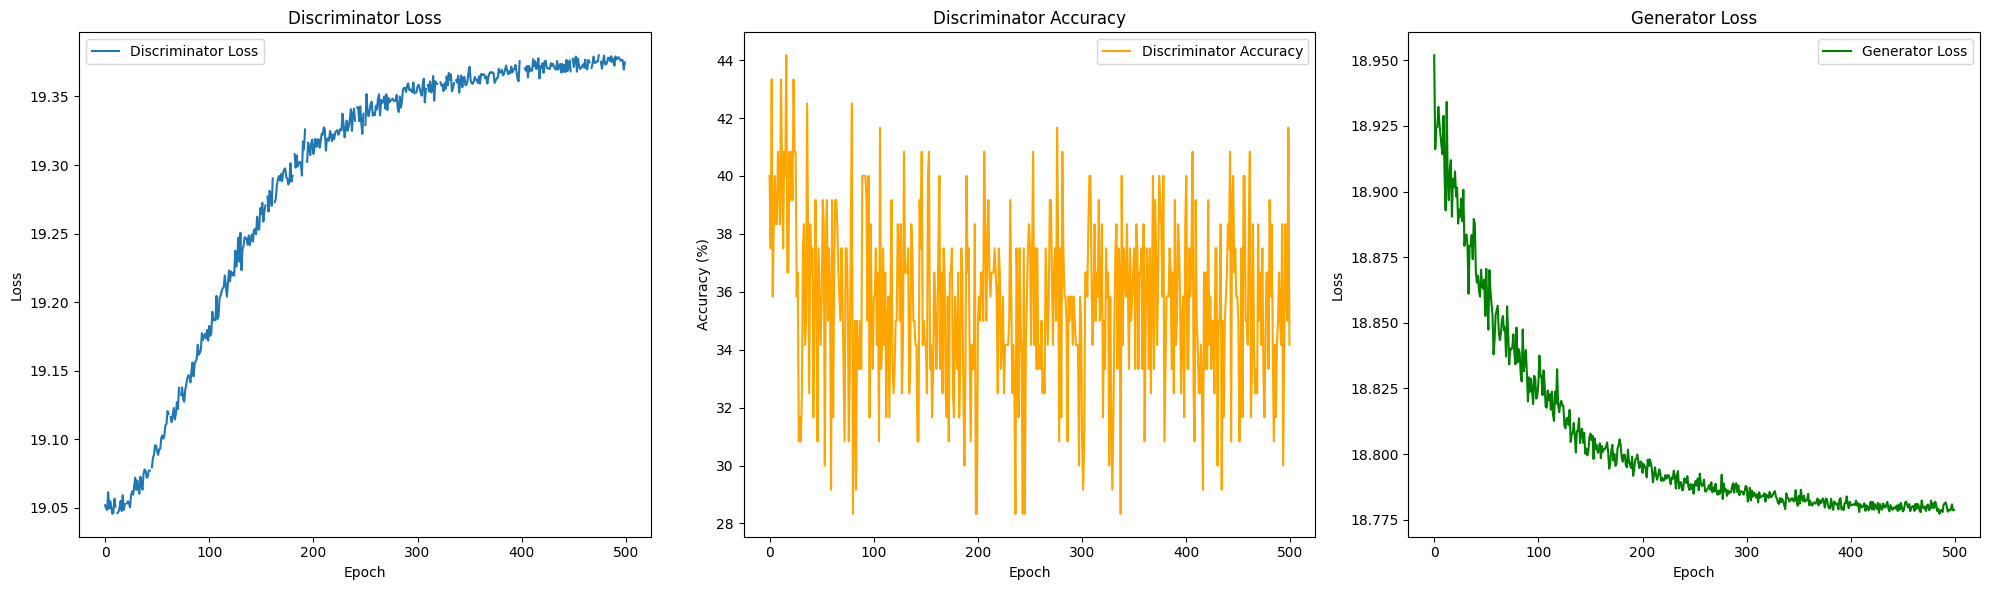

In [55]:
#--------------------------------------------------------------------------------
# Module 7: Visualize the Loss and Accuracy
#--------------------------------------------------------------------------------

import matplotlib.pyplot as plt

# Create a new figure for the plots
plt.figure(figsize=(20, 6))

# Plotting Discriminator Loss
plt.subplot(1, 3, 1)
plt.plot(d_losses, label='Discriminator Loss')
plt.title('Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Discriminator Accuracy
plt.subplot(1, 3, 2)
plt.plot(d_accuracies, label='Discriminator Accuracy', color='orange')
plt.title('Discriminator Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plotting Generator Loss
plt.subplot(1, 3, 3)
plt.plot(g_losses, label='Generator Loss', color='green')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [56]:
#--------------------------------------------------------------------------------
# Module 7.5: Inspect Newly Generated Samples from GAN
# This module generates new samples using the GAN and prints them for inspection.
#--------------------------------------------------------------------------------

def print_generated_samples(generator, num_samples=20):
    # Generate synthetic data using the GAN
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)

    # Convert generated samples to DataFrame for easy viewing
    generated_df = pd.DataFrame(generated_samples, columns=data_encoded.columns)
    print(generated_df.head(num_samples))

# Assuming your GAN's generator is properly trained and named 'generator'
print_generated_samples(generator)


1/1 [==============================] - 0s 11ms/step
    Upfront Payment  Leg 1 Fixed Rate  Leg 1 Spread  Leg 1 Notional  \
0         -0.842069          0.585397      0.689263        0.286583   
1         -0.609995         -0.253732     -0.677153       -0.701965   
2          0.288653          0.059900      0.233159        0.187541   
3          0.094651          0.716468     -0.574325        0.318105   
4         -0.909406          0.610129     -0.651732       -0.671397   
5         -0.857277         -0.557970     -0.579643       -0.482754   
6          0.146859          0.103792     -0.496454       -0.785801   
7          0.127509         -0.429389     -0.541853        0.768395   
8         -0.786182          0.105863      0.551046       -0.171136   
9         -0.607694          0.591021      0.426568        0.398712   
10        -0.762806          0.576154     -0.175852       -0.559162   
11         0.652112          0.305352      0.065866        0.339247   
12         0.040081      

In [57]:
#--------------------------------------------------------------------------------
# Module 8: Synthetic Data Generation and Inverse Transformation
# 1. This module defines a function to generate synthetic data samples using a GAN.
# 2. It then inverses the one-hot encoding and normalization transformations to obtain
# data in a format similar to the original input data. The resulting synthetic data 
# is then printed for inspection. 
#--------------------------------------------------------------------------------

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def generate_and_inverse_transform(generator, num_samples=20):
    # 1. Generate synthetic data using the GAN
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)

    # Convert generated samples to DataFrame
    generated_df = pd.DataFrame(generated_samples, columns=data_encoded.columns)
    
    # 2. Inverse one-hot encoding to get original categorical columns
    for original_col in original_categorical_columns:
        one_hot_cols = [col for col in generated_df.columns if col.startswith(original_col + "_")]
        if one_hot_cols:
            generated_df[original_col] = generated_df[one_hot_cols].idxmax(axis=1).str.replace(original_col + "_", "")
            generated_df.drop(one_hot_cols, axis=1, inplace=True)

    # 3. Inverse normalization to get the original values of numerical columns
    generated_df[numerical_columns] = scaler.inverse_transform(generated_df[numerical_columns])

    # Ensure all columns from the original data are present in generated_df
    for col in data.columns:
        if col not in generated_df.columns:
            generated_df[col] = np.nan
    
    # Ensure the columns are in the same order as the original data
    generated_df = generated_df[data.columns]
    
    return generated_df

# Assuming you have your original dataframe named 'data' loaded from CSV
data = pd.read_csv("Cleaned Data/RT.IRS_Clean_v3.csv")

# Recreate the scaler object
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Identify original categorical columns before one-hot encoding
original_categorical_columns = data.select_dtypes(include=['object']).columns

# Call the function and print synthetic data
synthetic_data = generate_and_inverse_transform(generator)
print(synthetic_data)


1/1 [==============================] - 0s 9ms/step
                  Event          Cleared       Collateralization  \
0                  Void  Intend to Clear                     nan   
1           Compression        Uncleared                     nan   
2       PARTIAL_NETTING  Intend to Clear  One-Way Collateralized   
3           TRANSFER_IN  Intend to Clear        Uncollateralized   
4           TRANSFER_IN  Intend to Clear        Uncollateralized   
5          FULL_NETTING          Cleared  One-Way Collateralized   
6       NETTING_REMNANT  Intend to Clear                     nan   
7   Partial Swap Unwind          Cleared        Uncollateralized   
8          Cancellation          Cleared  One-Way Collateralized   
9              Snapshot        Uncleared  One-Way Collateralized   
10            New Trade          Cleared                     nan   
11           Correction  Intend to Clear  One-Way Collateralized   
12      NETTING_REMNANT        Uncleared        Uncollateralized 

In [58]:
#--------------------------------------------------------------------------------
# Module 9: Generate Synthesized Data and Save to CSV
#--------------------------------------------------------------------------------
output_file_path = "Synthesized data/RT.IRS_Clean_v1.csv"

def save_synthesized_data(generator, num_samples=1000, output_file_path="Synthesized Data/synthesized_data.csv"):
    # Generate synthetic data
    synthetic_data = generate_and_inverse_transform(generator, num_samples=num_samples)
    
    # Save the synthesized data to a CSV file
    synthetic_data.to_csv(output_file_path, index=False)
    
    print(f"Synthesized data generated and saved to {output_file_path}")

# Call the function to generate and save the synthetic data
save_synthesized_data(generator)


32/32 [==============================] - 0s 1ms/step
Synthesized data generated and saved to Synthesized Data/synthesized_data.csv
